The northward heat transport seems to depend on the averaging period.

Calculating heat transport at every time-step (diaptr) and later averaging is preferable.

Using averaged T and V fields to calculate heat transport later (CDFTOOLS or python etc.) produces "spikes" around the equator.

In [1]:
from glob import glob
import numpy as np
import xarray as xr
from cmocean import cm
from matplotlib import pyplot as plt
import xgcm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [2]:
in_path = '/scratch/usr/shkifmjr/OMIP/GEOMAR05.JRAbgc-cycle6/'

Load the diaptr files written by NEMO (here, heat transports are calculated at every time step and then later averaged to write the output)

In [3]:
diaptr = xr.open_mfdataset(sorted(glob(in_path + 'OUT/GEOMAR05.JRAbgc-cycle6_1y_????0101_????1231_diaptr.nc'))).isel(x_gznl=500)

Load the heat transports calculated by the CDFTOOLS (here heat transport is calulated from yearly averaged temperature and velocity)

In [4]:
hfpath = in_path + 'omip_data/GEOMAR05.JRAbgc-cycle6_1y_19580101_20181231_hfbasin_'
hfbasin = xr.open_dataset(hfpath + 'global.nc')
hfbasin = hfbasin.update({'hfbasin_atl': xr.open_dataset(hfpath + 'atl.nc')['hfbasin_atl']})
hfbasin = hfbasin.update({'hfbasin_pac': xr.open_dataset(hfpath + 'pac.nc')['hfbasin_pac']})
hfbasin = hfbasin.update({'hfbasin_ind': xr.open_dataset(hfpath + 'ind.nc')['hfbasin_ind']})
hfbasin = hfbasin.update({'hfbasin_indpac': xr.open_dataset(hfpath + 'indpac.nc')['hfbasin_indpac']})

Load the grid_T and grid_V files from NEMO to calculate heat transport with python (this is to exclude the possibilty that there is an error in the CDFTOOLS)

In [5]:
grid_T = xr.open_mfdataset(glob(in_path + 'OUT/GEOMAR05.JRAbgc-cycle6_1y_20080101_20081231_grid_T.nc')).rename({'deptht': 'depthv'})
grid_V = xr.open_mfdataset(glob(in_path + 'OUT/GEOMAR05.JRAbgc-cycle6_1y_20080101_20081231_grid_V.nc'))
basins = xr.open_dataset(in_path + 'omip_data/new_maskglo.nc').rename({'X': 'x', 'Y': 'y'})
mhgr = xr.open_dataset(in_path + 'omip_data/mesh_hgr.nc').rename({'z': 'depthv', 't': 'time_counter'})
mzgr = xr.open_dataset(in_path + 'omip_data/mesh_zgr.nc').rename({'z': 'depthv', 't': 'time_counter'})
mask = xr.open_dataset(in_path + 'omip_data/mask.nc').rename({'z': 'depthv', 't': 'time_counter'})
pprau0 = 1000.
pprcp  = 4000.

In [6]:
temp = grid_T['votemper']
v = grid_V['vomecrty']

In [7]:
trans = 0.5 * (temp[:,:,0:-1,:] + temp[:,:,1::,:]) * v[:,:,0:-1,:]

In [8]:
trans_vert = (trans * mhgr['e1v'][:,0:-1,:] * mzgr['e3t_0'][:,:,0:-1,:] * pprau0 * pprcp).sum('depthv')

In [9]:
trans_vert_test = (trans[:,::-1,:,:] * mhgr['e1v'][:,0:-1,:] * mzgr['e3t_0'][:,::-1,0:-1,:] * pprau0 * pprcp).sum('depthv')

In [10]:
trans_pac = (trans_vert * mask['tmask'][0,0,0:-1,:]).sum('x') / 1e15

In [11]:
trans_pac_test = (trans_vert_test * mask['tmask'][0,0,0:-1,:]).sum('x') / 1e15

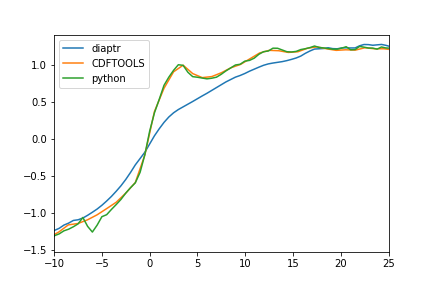

In [12]:
plt.plot(diaptr['nav_lat_gznl'], diaptr.isel(time_counter=50)['sopht_vt'], label='diaptr')
plt.plot(hfbasin['lat'], hfbasin.isel(time=50)['hfbasin_global'].where(hfbasin.isel(time=10)['hfbasin_global'] < 1000), label='CDFTOOLS')
plt.plot(mhgr['nav_lat'][0:-1,100].squeeze(), trans_pac.squeeze(), label='python')
plt.xlim(-10, 25)
plt.legend()

Test everything with 5d 1m and 1y mean calculations compared to diaptr

In [13]:
orion_path = '/scratch/usr/shkifmjr/ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01/OUT/'

In [14]:
diaptr_o = xr.open_dataset(orion_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_1m_20050101_20051231_diaptr.nc')

In [24]:
grid_T_1m = xr.open_dataset(orion_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_1m_20050101_20051231_grid_T.nc').rename({'deptht': 'depthv'})
grid_V_1m = xr.open_dataset(orion_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_1m_20050101_20051231_grid_V.nc')

In [25]:
grid_T_5d = xr.open_dataset(orion_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d_20050101_20051231_grid_T.nc').rename({'deptht': 'depthv'})
grid_V_5d = xr.open_dataset(orion_path + 'ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP01_5d_20050101_20051231_grid_V.nc')

In [26]:
temp_1m = grid_T_1m['votemper']
v_1m = grid_V_1m['vomecrty']

In [27]:
temp_1y = temp_1m.mean('time_counter')
v_1y = v_1m.mean('time_counter')

In [28]:
temp_5d = grid_T_5d['votemper']
v_5d = grid_V_5d['vomecrty']

In [29]:
trans_1y = 0.5 * (temp_1y[:,0:-1,:] + temp_1y[:,1::,:]) * v_1y[:,0:-1,:]

In [44]:
trans_1m = 0.5 * (temp_1m[:,:,0:-1,:] + temp_1m[:,:,1::,:]) * v_1m[:,:,0:-1,:]

In [46]:
trans_5d = 0.5 * (temp_5d[:,:,0:-1,:] + temp_5d[:,:,1::,:]) * v_5d[:,:,0:-1,:]

In [47]:
trans_vert_1y = (trans_1y * mhgr['e1v'][:,0:-1,:].squeeze() * mzgr['e3t_0'][:,:,0:-1,:].squeeze() * pprau0 * pprcp).sum('depthv')

In [48]:
trans_vert_1m = (trans_1m * mhgr['e1v'][:,0:-1,:].squeeze() * mzgr['e3t_0'][:,:,0:-1,:].squeeze() * pprau0 * pprcp).sum('depthv')

In [50]:
trans_vert_5d = (trans_5d * mhgr['e1v'][:,0:-1,:].squeeze() * mzgr['e3t_0'][:,:,0:-1,:].squeeze() * pprau0 * pprcp).sum('depthv')

In [53]:
trans_pac_1y = (trans_vert_1y * basins['tmaskpac'][0:-1,:]).sum('x') / 1e15

In [56]:
trans_pac_1m = (trans_vert_1m * basins['tmaskpac'][0:-1,:]).sum('x') / 1e15

In [57]:
trans_pac_5d = (trans_vert_5d * basins['tmaskpac'][0:-1,:]).sum('x') / 1e15

(0, 20)

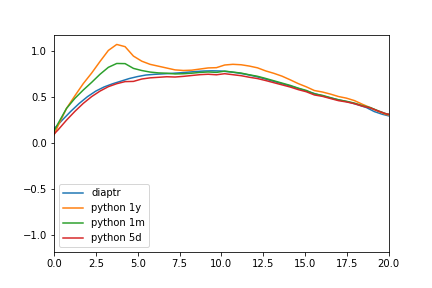

In [62]:
plt.plot(diaptr_o['nav_lat_gznl'].isel(x_gznl=500), diaptr_o['sopht_vt_pac'].isel(x_gznl=500).mean('time_counter'), label='diaptr')
plt.plot(trans_1y['nav_lat'].isel(x=500), trans_pac_1y, label='python 1y')
plt.plot(trans_1y['nav_lat'].isel(x=500), trans_pac_1m.mean('time_counter'), label='python 1m')
plt.plot(trans_1y['nav_lat'].isel(x=500), trans_pac_5d.mean('time_counter'), label='python 5d')
plt.legend()
plt.xlim(0, 20)